In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task 1

In [ ]:
# IMPORTANT:
#   Whenever you start a new colab runtime, use the following code to download
#   the training dataset onto the runtime local storage.
#   This should take ~3-5 mins for the whole dataset.
#   You can then load data from the local storage (/content/data)
#   into your colab
#   notebook using the `h5py` library (see example below).
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project",
                filename="train.h5", repo_type="dataset", local_dir="data")
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project",
                filename="events.csv", repo_type="dataset", local_dir="data")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.h5:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

events.csv:   0%|          | 0.00/782k [00:00<?, ?B/s]

'data/events.csv'

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from keras.models import Sequential
import tensorflow as tf
from keras.layers import ConvLSTM2D, Conv3D, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.saving
import glob
import h5py
import IPython
import PIL
import matplotlib.pyplot as plt
import os
import io
import cv2

## Prepare the data

In [ ]:
# this DataFrame contains all of the event meta data
df = pd.read_csv("data/events.csv", parse_dates=["start_utc"])
event_ids = df["id"].unique()

np.random.seed(42)  # Ensure consistent data division

np.random.shuffle(event_ids)  # disrupt the order

# Split the data set proportionally
train_split = int(0.7 * len(event_ids))  # 70%
val_split = int(0.2 * len(event_ids))    # 20%

train_ids = event_ids[:train_split]
val_ids = event_ids[train_split:train_split + val_split]
test_ids = event_ids[train_split + val_split:]

print(f"Train: {len(train_ids)}, Val: {len(val_ids)}, Test: {len(test_ids)}")

Train: 560, Val: 160, Test: 80


## Data Preprocessing for Task 1

In [ ]:
def task1_normalize_data(data):
  """
    Normalizes the input data by scaling values to the range [0, 1].

    Parameters:
    ----------
        data : np.ndarray
            The input array to be normalized.

    Returns:
    -------
        np.ndarray
            The normalized array where values are scaled to [0,1].
  """
  return (data - data.min()) / (data.max() - data.min() + 1e-6)

def task1_load_multichannel_data(file_path, event_id):
    """
    Reads storm data from an HDF5 file and processes Task 1A and Task 1B.

    Parameters:
    ----------
        file_path : str
            The path to the HDF5 file containing storm event data.
        event_id : str
            The event identifier used to extract relevant data from the file.

    Returns:
    -------
        tuple of np.ndarray
            - resized_vis : np.ndarray
                Resized visible spectrum data with shape (192, 192, T).
            - ir069 : np.ndarray
                Infrared 6.9μm channel data.
            - ir107 : np.ndarray
                Infrared 10.7μm channel data.
            - resized_vil : np.ndarray
                Resized vertical integrated liquid (VIL) data with shape
                (192, 192, T).
    """
    with h5py.File(file_path, "r") as f:
        vil = f[event_id]["vil"][:]
        vis = f[event_id]["vis"][:]
        ir069 = f[event_id]["ir069"][:]
        ir107 = f[event_id]["ir107"][:]

        vil = task1_normalize_data(vil)
        vis = task1_normalize_data(vis)
        ir069 = task1_normalize_data(ir069)
        ir107 = task1_normalize_data(ir107)

        T = vis.shape[2]

        # Resize vis, vil to (192, 192)
        resized_vis = np.array([cv2.resize(vis[:, :, i],
                                             (192, 192)) \
                                 for i in range(T)]).transpose(1, 2, 0)
        resized_vil = np.array([cv2.resize(vil[:, :, i],
                                             (192, 192)) \
                                 for i in range(T)]).transpose(1, 2, 0)

        return resized_vis, ir069, ir107, resized_vil

### Slide windows

In [ ]:
def task1_preprocess_batch(file_path, event_ids,
                                 save_filename, batch_size=40):
    """
    Processes storm events in batches and saves them in compressed files to
    optimize RAM usage.

    Parameters:
    ----------
        file_path : str
            The path to the HDF5 file containing storm event data.
        event_ids : list of str
            A list of event identifiers to process.
        save_filename : str
            The base filename for saving the processed data.
        batch_size : int, optional
            The number of storms processed and saved in a single batch
            (default: 40).

    Returns:
    -------
        None
    """

    os.makedirs("data/train", exist_ok=True)
    os.makedirs("data/val", exist_ok=True)
    os.makedirs("data/test", exist_ok=True)

    start_frames = [0, 2, 4, 6, 8, 10, 12]  # 800 * 7
    all_X, all_Y = [], []
    batch_idx = 0

    for i, event_id in enumerate(event_ids):
        try:
            vis, ir069, ir107, vil = \
            task1_load_multichannel_data(file_path, event_id)

            for start in start_frames:
                all_Y.append(vil[:, :, start+12:start+24])  # Output VIL
                all_X.append(np.stack([ir069[:, :, start:start+12], #1
                                       ir107[:, :, start:start+12], #2
                                       vil[:, :, start:start+12], #3
                                       vis[:, :, start:start+12]],  #4
                                       axis=-1))  # 4-Channel Input

        except Exception as e:
            print(f"Error processing {event_id}: {e}")

        # Each 'batch_size' storm is saved once, freeing RAM
        if (i + 1) % batch_size == 0 or (i + 1) == len(event_ids):
          # local save
          np.savez_compressed(f"data/{save_filename}/{save_filename}_batch{batch_idx}.npz",
                              X=np.array(all_X), Y=np.array(all_Y))
          all_X, all_Y = [], []  # Clear RAM and continue processing
          batch_idx += 1

In [ ]:
# Process and store one by one
task1_preprocess_batch("data/train.h5", train_ids, "train")

In [ ]:
task1_preprocess_batch("data/train.h5", val_ids, "val")
task1_preprocess_batch("data/train.h5", test_ids, "test")

## Train the model

### Load preprocessing data

In [ ]:
def task1_load_npz_generator(data_dir):
    """
    Lazily loads and yields data samples from compressed `.npz` files
    in a specified directory.

    This approach prevents excessive memory usage by reading data incrementally.

    Parameters:
    ----------
        data_dir : str
            The directory containing `.npz` files with preprocessed storm event
            data.

    Yields:
    -------
        tuple (np.ndarray, np.ndarray)
            - X : np.ndarray
                The input sample with multiple channels.
            - Y : np.ndarray
                The corresponding output sample with an additional
                singleton dimension.
    """

    files = sorted(glob.glob(f"{data_dir}/*.npz"))

    for file in files:
        data = np.load(file)
        X, Y = data["X"], data["Y"]

        for i in range(len(X)):  # Each '.npz 'may contain multiple samples
            yield X[i], np.expand_dims(Y[i], axis=-1)
            # Return samples one by one to avoid full RAM


In [ ]:
def task1_get_tf_dataset(task, data_dir, batch_size=1):
    """
    Creates a TensorFlow dataset from a generator, processing storm data for
    Task 1A or Task 1B.

    Parameters:
    ----------
        task : str
            The task identifier ("1A" or "1B").
        data_dir : str
            The directory containing `.npz` files with preprocessed
            storm event data.
        batch_size : int, optional
            The number of samples per batch (default: 1).

    Returns:
    -------
        tf.data.Dataset
            A TensorFlow dataset that yields batches of (X, Y)
            tensors for training or evaluation.
    """

    dataset = tf.data.Dataset.from_generator(
        lambda: task1_load_npz_generator(data_dir),
        output_signature=(
            tf.TensorSpec(shape=(192, 192, 12, 4), dtype=tf.float32),  # X
            tf.TensorSpec(shape=(192, 192, 12, 1), dtype=tf.float32),  # Y
        )
    )

    # only vil
    if task == "1A":
        dataset = dataset.map(lambda X, Y: (X[..., 2:3], Y),
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
    elif task == "1B":
        dataset = dataset.map(lambda X, Y: (X, Y),
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.batch(batch_size).shuffle(1000) \
              .prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
# RMSE
@keras.saving.register_keras_serializable()
def t1_rmse(y_true, y_pred):
    return tf.math.sqrt(tf.reduce_mean(tf.math.square(y_true - y_pred)))

# MAE
@keras.saving.register_keras_serializable()
def t1_mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

# KL divergence
@keras.saving.register_keras_serializable()
def t1_kl_divergence(y_true, y_pred):
    y_true = tf.clip_by_value(y_true, 1e-10, 1)  # avoid log(0)
    y_pred = tf.clip_by_value(y_pred, 1e-10, 1)

    # Make sure that y_true and y_pred are normalized
    y_true = y_true / tf.reduce_sum(y_true, axis=-1, keepdims=True)
    y_pred = y_pred / tf.reduce_sum(y_pred, axis=-1, keepdims=True)
    return tf.reduce_mean(y_true * tf.math.log(y_true / (y_pred + 1e-10)))

# reconstruction loss
@keras.saving.register_keras_serializable()
def t1_reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.math.square(y_true - y_pred))

# total loss = reconstruction loss + KL divergence
@keras.saving.register_keras_serializable()
def t1_total_loss(y_true, y_pred):
    return t1_reconstruction_loss(y_true, y_pred) + t1_kl_divergence(y_true, y_pred)

### Task 1A

In [ ]:
train_datasetA = task1_get_tf_dataset("1A", "data/train")
val_datasetA = task1_get_tf_dataset("1A", "data/val")
test_datasetA = task1_get_tf_dataset("1A", "data/test")

In [ ]:
def task1_build_model(input_shape):
    """
    Builds a ConvLSTM2D-based deep learning model for Task 1.

    Parameters:
    ----------
        input_shape : tuple
            The shape of the input tensor (height, width, time steps, channels).

    Returns:
    -------
        model : tf.keras.Model
            A compiled ConvLSTM2D model for storm prediction.
    """

    model = Sequential()

    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                         padding='same', return_sequences=True,
                         input_shape=input_shape))

    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                         padding='same', return_sequences=True))

    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                         padding='same', return_sequences=True))

    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation='sigmoid',
                     padding='same'))

    return model

# Train the model
# For task 1A
input_shape = (192, 192, 12, 1)
modela = task1_build_model(input_shape)


In [ ]:
modela.compile(optimizer='adam',
              loss="mae",
              metrics=[total_loss, mae, rmse, kl_divergence,
                       reconstruction_loss])

In [ ]:
# Train and monitor Task 1A
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                               restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=1e-6)


def task1_count_files(data_dir, batch_size=40):
    num_files = len(glob.glob(f"{data_dir}/*.npz"))
    return num_files * batch_size * 7

train_steps_per_epoch = task1_count_files("data/train", batch_size=40)
val_steps_per_epoch = task1_count_files("data/val", batch_size=40)

print(f"Train steps per epoch: {train_steps_per_epoch}")
print(f"Validation steps per epoch: {val_steps_per_epoch}")

Train steps per epoch: 3920
Validation steps per epoch: 1120


### Train the model A

In [ ]:
train_datasetA = train_datasetA.repeat()
# Make the training data repeat automatically
val_datasetA = val_datasetA.repeat()

history = modela.fit(train_datasetA,
                    epochs=5,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_datasetA,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/5
3920/3920 ━━━━━━━━━━━━━━━━━━━━ 2099s 503ms/step - kl_divergence: 0.0000e+00 - loss: 0.0865 - mae: 0.0865 - reconstruction_loss: 0.0298 - rmse: 0.1537 - total_loss: 0.0298 - val_kl_divergence: 0.0000e+00 - val_loss: 0.0509 - val_mae: 0.0509 - val_reconstruction_loss: 0.0122 - val_rmse: 0.1058 - val_total_loss: 0.0122 - learning_rate: 0.0010
Epoch 2/5
3920/3920 ━━━━━━━━━━━━━━━━━━━━ 1977s 504ms/step - kl_divergence: 0.0000e+00 - loss: 0.0574 - mae: 0.0574 - reconstruction_loss: 0.0143 - rmse: 0.1137 - total_loss: 0.0143 - val_kl_divergence: 0.0000e+00 - val_loss: 0.0554 - val_mae: 0.0554 - val_reconstruction_loss: 0.0116 - val_rmse: 0.1033 - val_total_loss: 0.0116 - learning_rate: 0.0010
Epoch 3/5
3920/3920 ━━━━━━━━━━━━━━━━━━━━ 2124s 542ms/step - kl_divergence: 0.0000e+00 - loss: 0.0522 - mae: 0.0522 - reconstruction_loss: 0.0124 - rmse: 0.1064 - total_loss: 0.0124 - val_kl_divergence: 0.0000e+00 - val_loss: 0.0536 - val_mae: 0.0536 - val_reconstruction_loss: 0.0133 - val_rmse: 

In [ ]:
# Save the model to Google Drive
modela.save("/content/drive/MyDrive/task1a_model.keras")
print("Model saved")

Model saved


### Evaluation the model

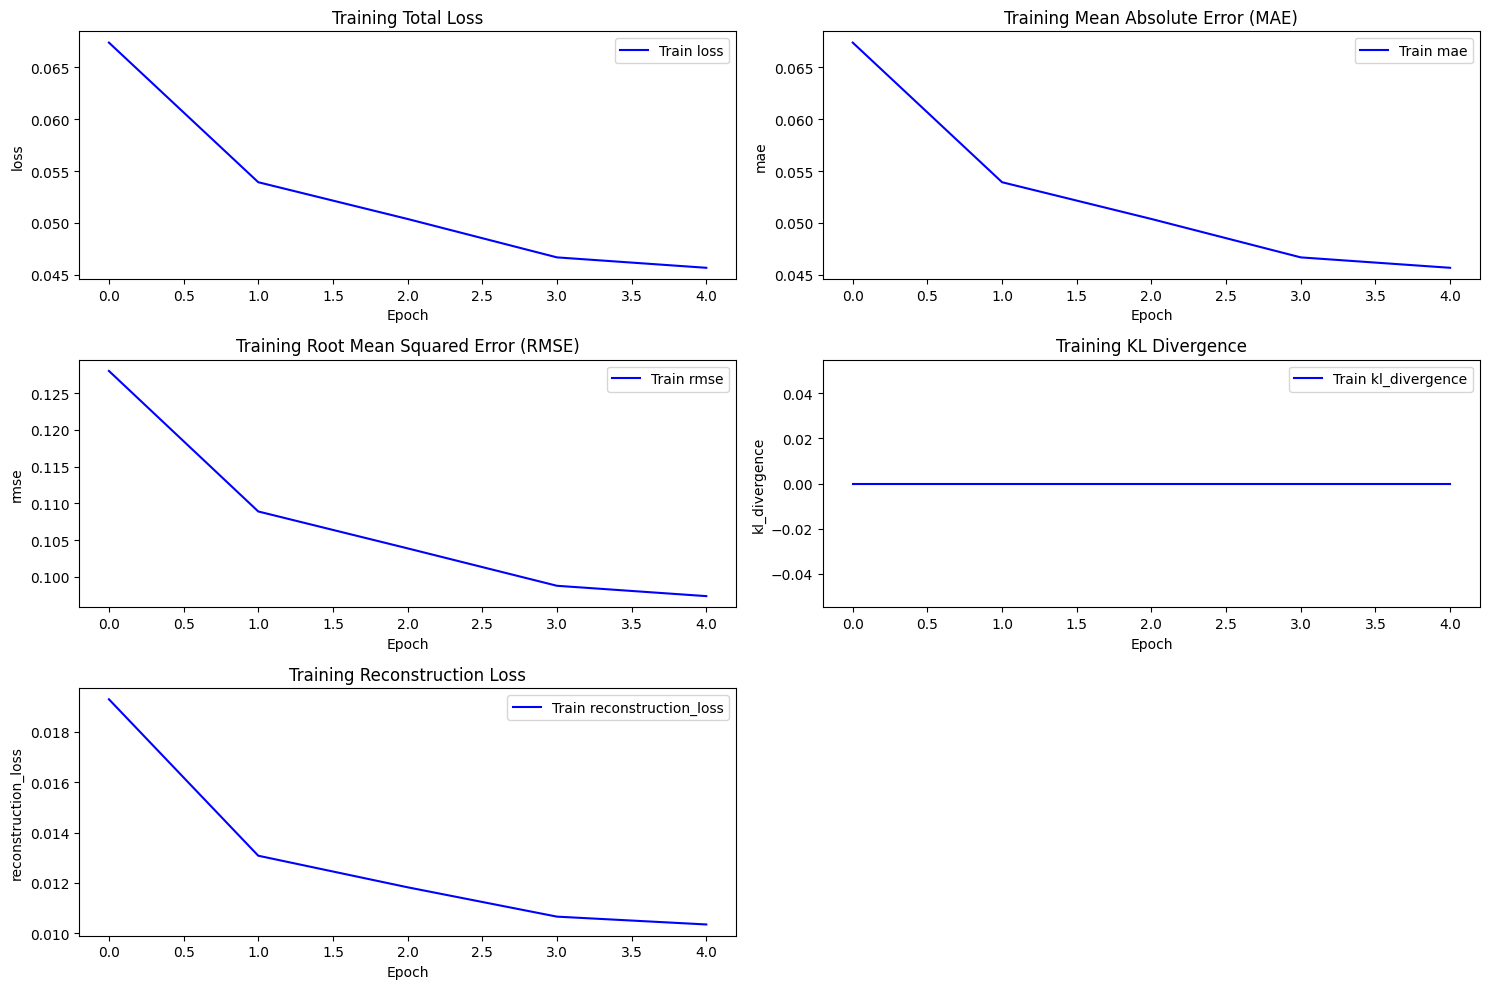

In [ ]:
def task1_plot_training_history(history):
    """
    Plots the training loss curves for various metrics.

    Parameters:
    ----------
        history : tf.keras.callbacks.History
            The history object returned by model.fit(),
            containing loss values and metrics.

    Returns:
    -------
        None
    """

    metrics = ['loss', 'mae', 'rmse', 'kl_divergence', 'reconstruction_loss']
    titles = ['Total Loss', 'Mean Absolute Error (MAE)',
              'Root Mean Squared Error (RMSE)',
              'KL Divergence', 'Reconstruction Loss']

    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics):
        plt.subplot(3, 2, i + 1)
        plt.plot(history.history[metric], label=f'Train {metric}', color='blue')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.title(f'Training {titles[i]}')
        plt.legend()

    plt.tight_layout()
    plt.show()

task1_plot_training_history(history)

In [ ]:
def task1_evaluate_test_set(model, test_dataset):
    """
    Evaluates the model on a test dataset and computes RMSE, MAE,
    KL-Divergence, Reconstruction Loss, and Total Loss.

    Parameters:
    ----------
        model : tf.keras.Model
            The trained model to be evaluated.
        test_dataset : tf.data.Dataset
            The test dataset containing input-output pairs.

    Returns:
    -------
        None
    """

    total_rmse, total_mae, total_kl, total_recon, total_loss_sum = 0, 0, 0, 0, 0
    num_samples = 0

    for X_batch, Y_batch in test_dataset:
        Y_pred = model.predict(X_batch, verbose=0)

        batch_rmse = tf.sqrt(tf.reduce_mean(tf.square(Y_batch - Y_pred))).numpy()
        batch_mae = tf.reduce_mean(tf.abs(Y_batch - Y_pred)).numpy()

        Y_batch_safe = tf.clip_by_value(Y_batch, 1e-10, 1)
        Y_pred_safe = tf.clip_by_value(Y_pred, 1e-10, 1)
        batch_kl = tf.reduce_mean(Y_batch_safe * tf.math.log(Y_batch_safe / Y_pred_safe)).numpy()

        batch_recon = tf.reduce_mean(tf.square(Y_batch - Y_pred)).numpy()
        batch_total_loss = batch_recon + batch_kl

        total_rmse += batch_rmse
        total_mae += batch_mae
        total_kl += batch_kl
        total_recon += batch_recon
        total_loss_sum += batch_total_loss
        num_samples += 1

    print(f"Test RMSE: {total_rmse / num_samples:.5f}")
    print(f"Test MAE: {total_mae / num_samples:.5f}")
    print(f"Test KL Divergence: {total_kl / num_samples:.5f}")
    print(f"Test Reconstruction Loss: {total_recon / num_samples:.5f}")
    print(f"Test Total Loss: {total_loss_sum / num_samples:.5f}")

# Load saved model
saved = load_model("/content/drive/MyDrive/task1a_model.keras")

task1_evaluate_test_set(saved, test_datasetA)

Test RMSE: 0.09183
Test MAE: 0.04197
Test KL Divergence: 0.06719
Test Reconstruction Loss: 0.00929
Test Total Loss: 0.07648


#### Show the prediction frames

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


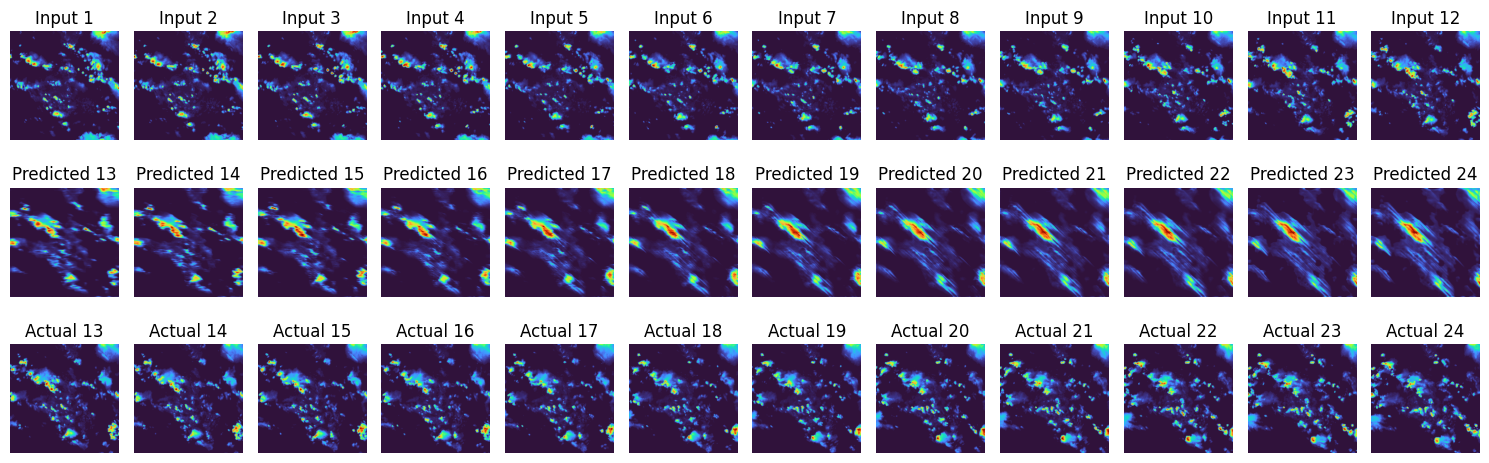

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


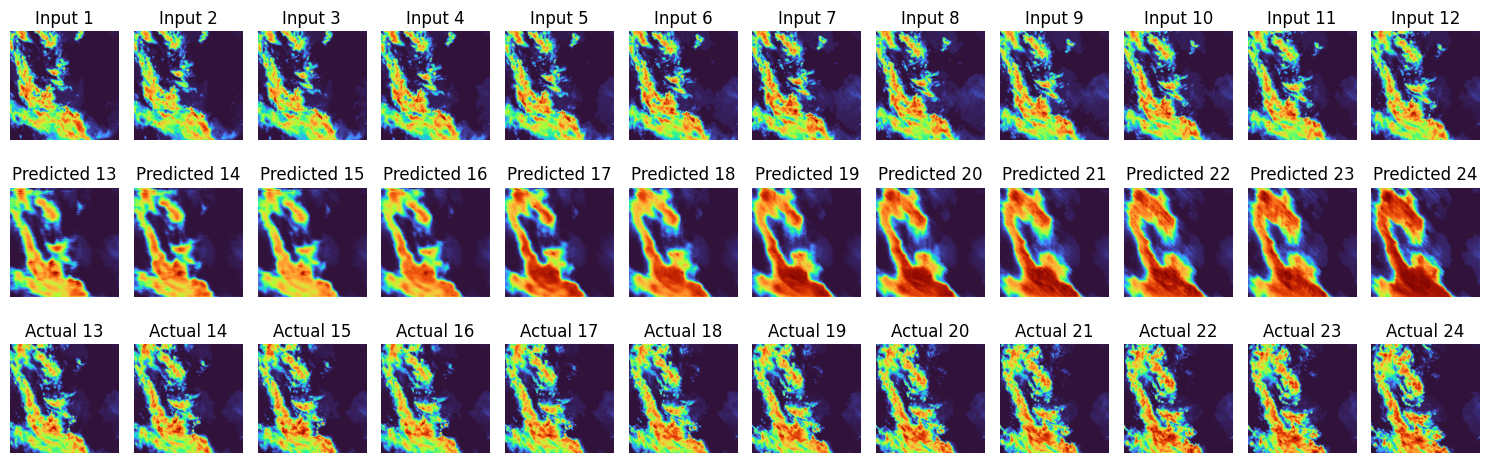

In [ ]:
def task1_predict_frames(model, X_input):
    """
      Uses the trained model to predict future frames based on input sequences.

      Parameters:
      ----------
          model : tf.keras.Model
              The trained model used for prediction.
          X_input : np.ndarray
              The input sequence of frames.

      Returns:
      -------
          np.ndarray
              The predicted future frames.
    """
    return model.predict(X_input)

def task1_plot_predicted_frames(initial_frames, predicted_frames, actual_frames):
    """
    Plots the input, predicted, and actual frames for visualization.

    Parameters:
    ----------
        initial_frames : np.ndarray
            The input frames used as context for prediction.
        predicted_frames : np.ndarray
            The frames predicted by the model.
        actual_frames : np.ndarray
            The ground truth future frames.

    Returns:
    -------
        None
    """

    num_frames = initial_frames.shape[3]
    plt.figure(figsize=(15, 5))
    for i in range(num_frames):
        plt.subplot(3, num_frames, i+1)
        plt.imshow(initial_frames[0, :, :, i, 0], cmap="turbo")
        plt.title(f"Input {i+1}")
        plt.axis('off')

    for i in range(num_frames):
        plt.subplot(3, num_frames, num_frames+i+1)
        plt.imshow(predicted_frames[0, :, :, i, 0], cmap="turbo")
        plt.title(f"Predicted {i+13}")
        plt.axis('off')

    for i in range(num_frames):
        plt.subplot(3, num_frames, 2*num_frames+i+1)
        plt.imshow(actual_frames[0, :, :, i, 0], cmap="turbo")
        plt.title(f"Actual {i+13}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Prediction

# Gets the iterator for the test set
test_iterator = iter(test_datasetA)

# First
X_sample, Y_sample = next(test_iterator)
predicted = task1_predict_frames(saved, X_sample.numpy())
task1_plot_predicted_frames(X_sample.numpy(), predicted, Y_sample.numpy())

# Second
X_sample1, Y_sample1 = next(test_iterator)
predicted1 = task1_predict_frames(saved, X_sample1.numpy())
task1_plot_predicted_frames(X_sample1.numpy(), predicted1, Y_sample1.numpy())

### Task 1B

In [ ]:
train_datasetB = task1_get_tf_dataset("1B", "data/train")
val_datasetB = task1_get_tf_dataset("1B", "data/val")
test_datasetB = task1_get_tf_dataset("1B", "data/test")

In [ ]:
# Train the model
# For compare, we use the same model
# For task 1B
input_shape_b = (192, 192, 12, 4)
model_b = task1_build_model(input_shape_b)

In [ ]:
model_b.compile(optimizer='adam',
                loss="mae",
                metrics=[total_loss, mae, rmse, kl_divergence,
                       reconstruction_loss])

In [ ]:
# Train and monitor Task 1A
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                               restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=1e-6)

def task1_count_files(data_dir, batch_size=40):
    num_files = len(glob.glob(f"{data_dir}/*.npz"))
    return num_files * batch_size * 7

train_steps_per_epoch = task1_count_files("data/train", batch_size=40)
val_steps_per_epoch = task1_count_files("data/val", batch_size=40)

print(f"Train steps per epoch: {train_steps_per_epoch}")
print(f"Validation steps per epoch: {val_steps_per_epoch}")


Train steps per epoch: 3920
Validation steps per epoch: 1120


### Train the model B

In [ ]:
train_datasetB = train_datasetB.repeat()
# Make the training data repeat automatically
val_datasetB = val_datasetB.repeat()

history_b = model_b.fit(train_datasetB,
                        epochs=5,
                        steps_per_epoch=train_steps_per_epoch,
                        validation_data=val_datasetB,
                        validation_steps=val_steps_per_epoch,
                        callbacks=[early_stopping, reduce_lr])

Epoch 1/5
3920/3920 ━━━━━━━━━━━━━━━━━━━━ 2482s 584ms/step - kl_divergence: 0.0000e+00 - loss: 0.0820 - mae: 0.0820 - reconstruction_loss: 0.0262 - rmse: 0.1464 - total_loss: 0.0262 - val_kl_divergence: 0.0000e+00 - val_loss: 0.0531 - val_mae: 0.0531 - val_reconstruction_loss: 0.0138 - val_rmse: 0.1121 - val_total_loss: 0.0138 - learning_rate: 0.0010
Epoch 2/5
3920/3920 ━━━━━━━━━━━━━━━━━━━━ 2195s 560ms/step - kl_divergence: 0.0000e+00 - loss: 0.0559 - mae: 0.0559 - reconstruction_loss: 0.0134 - rmse: 0.1107 - total_loss: 0.0134 - val_kl_divergence: 0.0000e+00 - val_loss: 0.0607 - val_mae: 0.0607 - val_reconstruction_loss: 0.0115 - val_rmse: 0.1039 - val_total_loss: 0.0115 - learning_rate: 0.0010
Epoch 3/5
3920/3920 ━━━━━━━━━━━━━━━━━━━━ 2133s 544ms/step - kl_divergence: 0.0000e+00 - loss: 0.0522 - mae: 0.0522 - reconstruction_loss: 0.0122 - rmse: 0.1058 - total_loss: 0.0122 - val_kl_divergence: 0.0000e+00 - val_loss: 0.0535 - val_mae: 0.0535 - val_reconstruction_loss: 0.0138 - val_rmse: 

In [ ]:
# Save the model to Google Drive
model_b.save("/content/drive/MyDrive/task1b_model.keras")
print("Model for B saved")

Model for B saved


### Evaluation the model

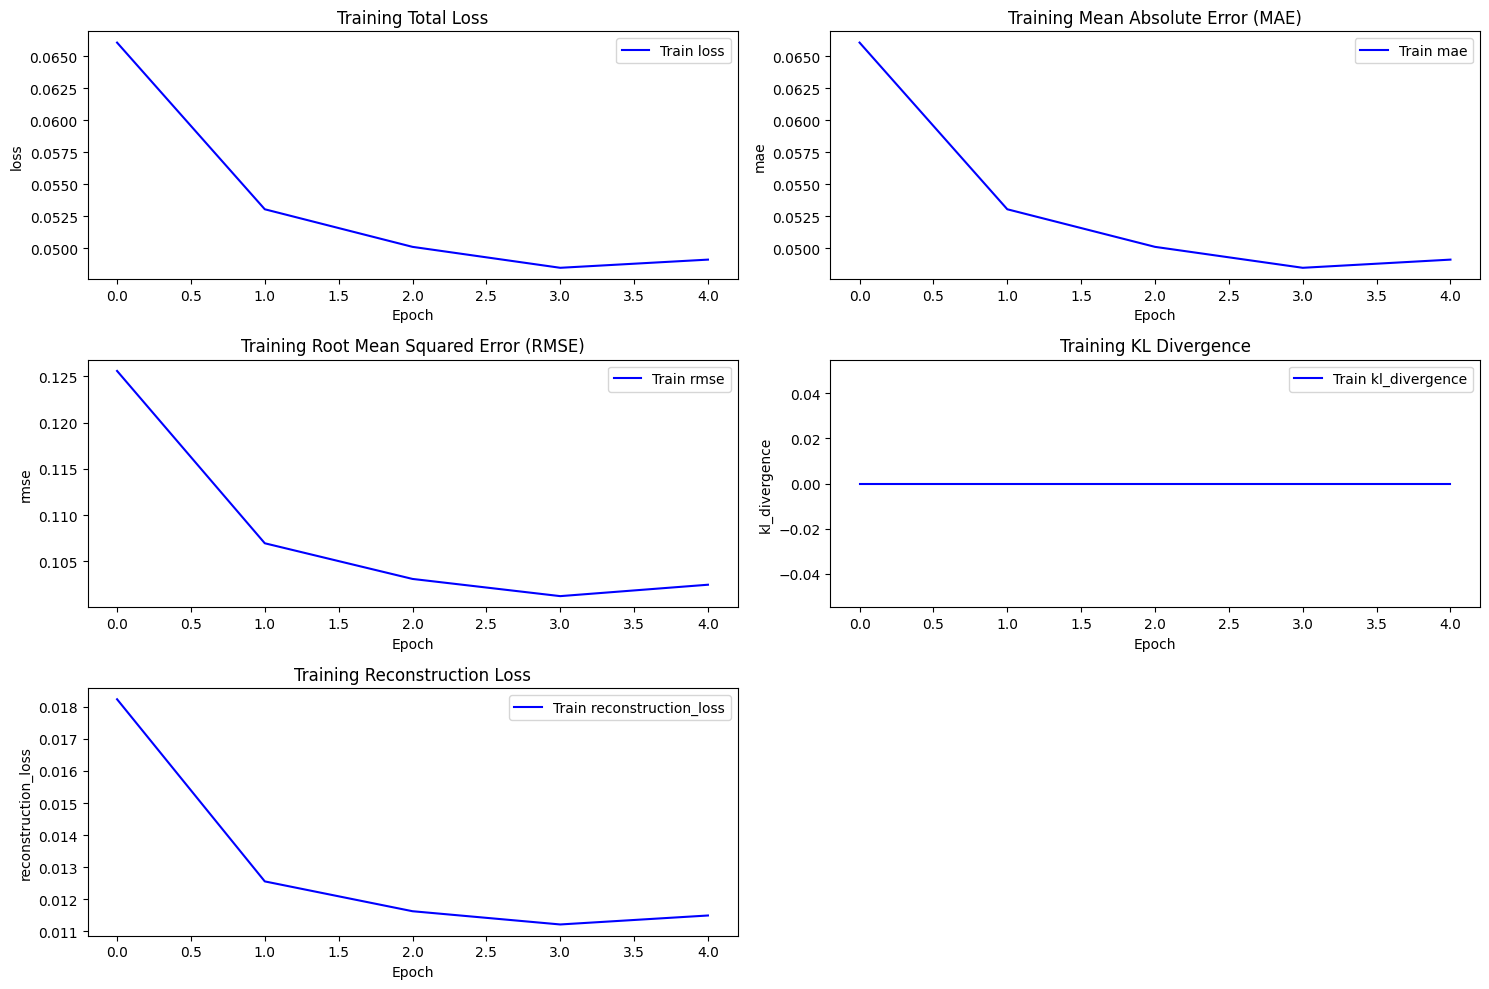

In [ ]:
# Plot Loss change curves for training and validation
task1_plot_training_history(history_b)

In [ ]:
# Load saved model
saved_b = load_model("/content/drive/MyDrive/task1b_model.keras")

# Evaluation of the 1B
task1_evaluate_test_set(saved_b, test_datasetB)

Test RMSE: 0.09582
Test MAE: 0.04592
Test KL Divergence: 0.06502
Test Reconstruction Loss: 0.01021
Test Total Loss: 0.07522


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


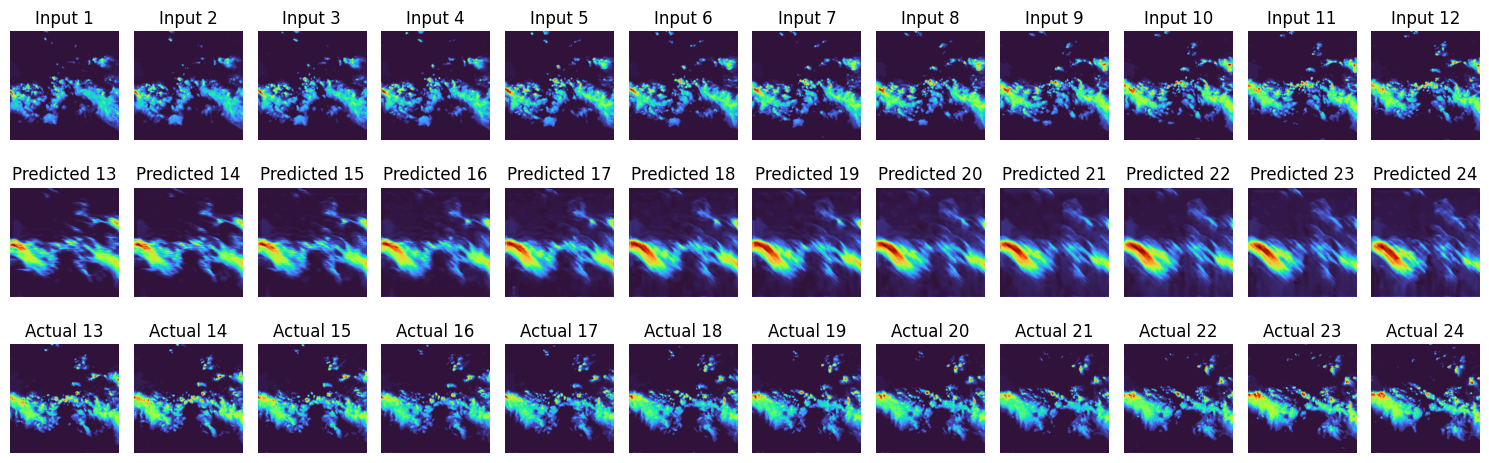

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


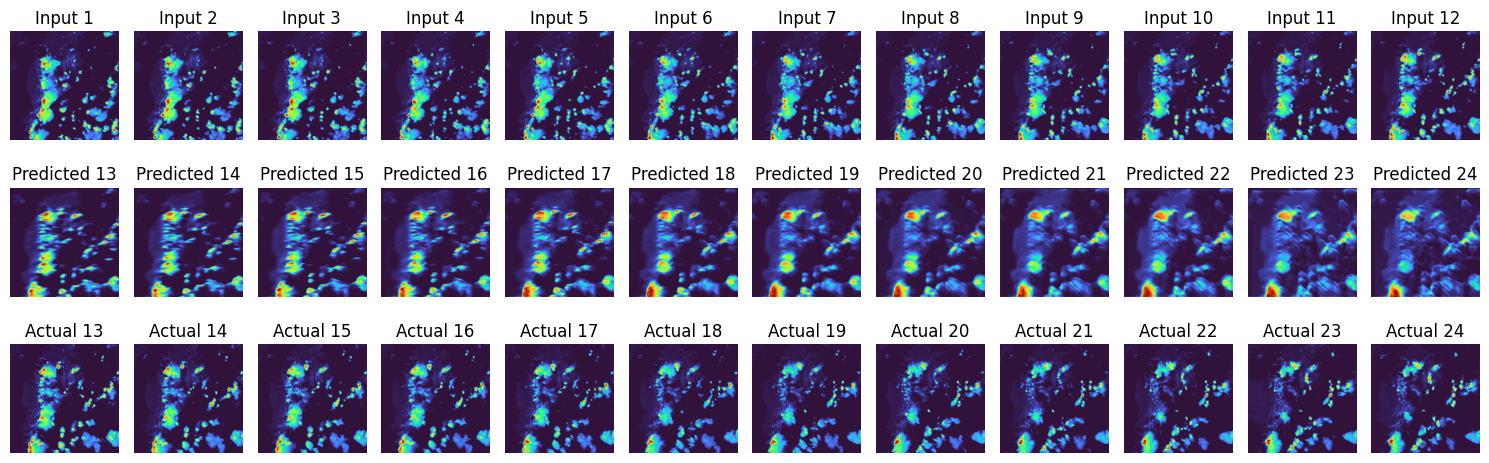

In [ ]:
# Prediction
def task1_plot_predicted_frames_b(initial_frames,
                                  predicted_frames, actual_frames):
    num_frames = initial_frames.shape[3]
    plt.figure(figsize=(15, 5))
    for i in range(num_frames):
        plt.subplot(3, num_frames, i+1)
        plt.imshow(initial_frames[0, :, :, i, 2], cmap="turbo")
        plt.title(f"Input {i+1}")
        plt.axis('off')

    for i in range(num_frames):
        plt.subplot(3, num_frames, num_frames+i+1)
        plt.imshow(predicted_frames[0, :, :, i, 0], cmap="turbo")
        plt.title(f"Predicted {i+13}")
        plt.axis('off')

    for i in range(num_frames):
        plt.subplot(3, num_frames, 2*num_frames+i+1)
        plt.imshow(actual_frames[0, :, :, i, 0], cmap="turbo")
        plt.title(f"Actual {i+13}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Gets the iterator for the test set
test_iterator2 = iter(test_datasetB)

# First
X_sample2, Y_sample2 = next(test_iterator2)
predicted2 = task1_predict_frames(saved_b, X_sample2.numpy())
task1_plot_predicted_frames_b(X_sample2.numpy(), predicted2, Y_sample2.numpy())

# Second
X_sample3, Y_sample3 = next(test_iterator2)
predicted3 = task1_predict_frames(saved_b, X_sample3.numpy())
task1_plot_predicted_frames_b(X_sample3.numpy(), predicted3, Y_sample3.numpy())

# Thought on Task 1

### Why did we choose this model?

We selected ConvLSTM2D and Conv3D as our primary deep learning architectures because they are well-suited for spatiotemporal prediction tasks. Meteorological and hydrological data often exhibit clear temporal patterns and spatial correlations, requiring a model that can effectively capture both dimensions. ConvLSTM is particularly advantageous in this context as it integrates convolutional operations with memory mechanisms, enabling it to model complex dependencies across time and space.

### Advantages of this model

Effective spatiotemporal feature extraction – ConvLSTM combines Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) networks, allowing it to learn both spatial structures and temporal dependencies. This makes it highly suitable for forecasting rainfall, river levels, and other time-series hydrological data.

Enhanced generalization ability – Compared to traditional LSTM or CNN models, ConvLSTM leverages spatial information more efficiently, improving predictive accuracy when handling multidimensional datasets.

### Innovations in our approach

#### Data augmentation

We incorporated augmentation and normalization techniques in data preprocessing to enhance the model’s generalizability.

Due to the imbalanced data distribution, augmentation techniques help balance the distribution, preventing the model from being biased toward more frequent patterns.

#### Optimization strategies

We applied EarlyStopping and ReduceLROnPlateau to mitigate overfitting and accelerate model convergence.

When training deep learning models with limited data, they tend to memorize specific patterns instead of learning generalizable features. Augmentation introduces variability, reducing overfitting and enhancing the model’s robustness in real-world applications.

#### Hyperparameter tuning

We fine-tuned key model parameters, including the number of layers, filter sizes, and dropout rates, to achieve optimal performance.